# TP5 Q-Learning avec FrozenLake-v1

In [3]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt


#### 1. Initialisation de l'environnement FrozenLake

https://gymnasium.farama.org/environments/toy_text/frozen_lake/


__Description__
Le jeu commence avec le joueur à l’emplacement [0,0] du monde de la grille du lac gelé avec l’objectif situé à l’extrémité du monde, par exemple [3,3] pour l’environnement 4x4.

Les trous dans la glace sont répartis à des endroits définis lorsqu’on utilise une carte prédéterminée ou à des endroits aléatoires lorsqu’une carte aléatoire est générée.

Le joueur effectue des mouvements jusqu’à ce qu’il atteigne l’objectif ou tombe dans un trou.

Le lac est glissant (à moins d’être désactivé), de sorte que le joueur peut parfois se déplacer perpendiculairement à la direction prévue (voir is_slippery).

Les mondes générés aléatoirement auront toujours un chemin vers l’objectif.

__Espace d’action__
La forme de l’action est (1,) dans la plage {0, 3} indiquant dans quelle direction déplacer le joueur.

- 0 : Se déplacer vers la gauche
- 1 : Descendez
- 2 : Se déplacer à droite
- 3 : Montez

__Espace d’observation__
L’observation est une valeur représentant la position actuelle du joueur comme current_row * ncols + current_col (où la rangée et le col commencent à 0).

Par exemple, la position de but sur la carte 4x4 peut être calculée comme suit : 3 * 4 + 3 = 15. 
Le nombre d’observations possibles dépend de la taille de la carte.

L’observation est renvoyée sous la forme d’un int().

__État de initial__
L’épisode commence avec le joueur dans l’état [0] (emplacement [0, 0]).

__Récompenses__
Barème des récompenses :

Atteindre l’objectif : +1
Trou de portée : 0
Portée congelée : 0

__Fin de l’épisode__
L’épisode se termine si ce qui suit se produit :

Terminaison:

- Le joueur se déplace dans un trou.
- Le joueur atteint l’objectif à max(nrow) * max(ncol) - 1 (emplacement [max(nrow)-1, max(ncol)-1]).
- Troncature (lors de l’utilisation de l’enveloppe time_limit) :
- La durée de l’épisode est de 100 pour l’environnement 4x4, 200 pour l’environnement FrozenLake8x8-v1.



In [4]:
env = gym.make('FrozenLake-v1', is_slippery=False)  # Set `is_slippery=False` to make the environment deterministic


### 2. Définir les hyperparamètres


In [6]:
n_actions = env.action_space.n  # Nombre d'actions (gauche, bas, droite, haut)
n_states = env.observation_space.n  # Nombre d'états (positions sur la grille)
init_value_qtable = 0
q_table = np.full(( n_states, n_actions), init_value_qtable, dtype=float)  # Initialisation de la Q-table avec des zéros
                        # max_length correspond HangedManEnv.max_word_size , by default 8 

learning_rate = 0.1  # Taux d'apprentissage
discount_factor = 0.99  # Facteur de réduction
epsilon = 1.0  # Epsilon initial pour l'exploration
epsilon_min = 0.01  # Epsilon minimal
epsilon_decay = 0.995  # Facteur de décroissance d'epsilon
n_episodes = 1000  # Nombre total d'épisodes d'entraînement
max_steps = 100  # Nombre maximal d'étapes par épisode

# Variables pour enregistrer l'évolution
rewards_per_episode = []  # Liste pour stocker les récompenses cumulées
td_errors_per_episode = []  # Liste pour stocker les erreurs de TD cumulées


### 3. Algorithme de Q-Learning

Adapter l'algorithme d'apprentissage du Q-learning à l'envirronement du Frozenlake. 

In [8]:
for episode in range(n_episodes):
    state, _ = env.reset()  # Réinitialiser l'environnement et récupérer l'état initial
    done = False
    total_reward = 0  # Récompense cumulée pour cet épisode
    total_td_error = 0  # Erreur de TD cumulée pour cet épisode

    for step in range(max_steps):
        # Choisir une action selon la politique epsilon-greedy
        if random.uniform(0, 1) < epsilon:
            # Exploration : Choisir une action aléatoire
            action = env.action_space.sample()
        else:
            # Exploitation : Choisir la meilleure action en fonction de la Q-table
            action = np.argmax(q_table[state, :])

        # Exécuter l'action et récupérer la récompense et l'état suivant
        next_state, reward, done, _, _ = env.step(action)

        # Mettre à jour la Q-table
        best_next_action = np.argmax(q_table[next_state, :])
        td_target = reward + discount_factor * q_table[next_state, best_next_action]  # Cible de la mise à jour
        td_error = td_target - q_table[state, action]  # Calcul de l'erreur de TD

        # Mise à jour de la Q-value
        q_table[state, action] += learning_rate * td_error

        # Accumuler les récompenses et les erreurs de TD
        total_reward += reward
        total_td_error += abs(td_error)

        # Passer à l'état suivant
        state = next_state

        # Si l'épisode est terminé
        if done:
            break

    # Réduire epsilon pour diminuer l'exploration au fil du temps
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Enregistrer les récompenses et l'erreur de TD cumulées pour cet épisode
    rewards_per_episode.append(total_reward)
    td_errors_per_episode.append(total_td_error)


### 4. Afficher les graphiques des récompenses et de l'erreur de TD


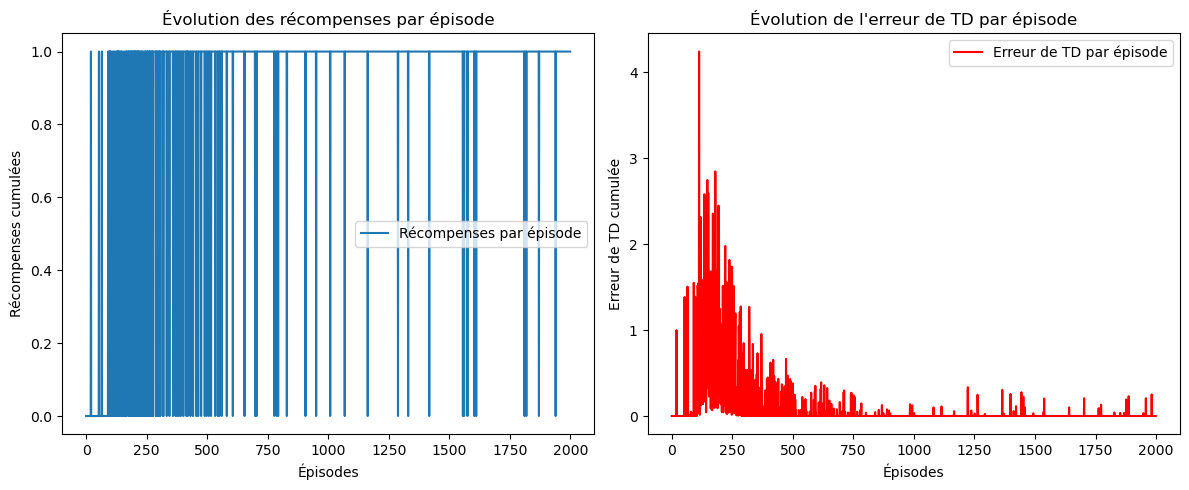

In [13]:
plt.figure(figsize=(12, 5))

# Graphique des récompenses
plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label='Récompenses par épisode')
plt.xlabel('Épisodes')
plt.ylabel('Récompenses cumulées')
plt.title("Évolution des récompenses par épisode")
plt.legend()

# Graphique des erreurs de TD
plt.subplot(1, 2, 2)
plt.plot(td_errors_per_episode, label='Erreur de TD par épisode', color='red')
plt.xlabel('Épisodes')
plt.ylabel('Erreur de TD cumulée')
plt.title("Évolution de l'erreur de TD par épisode")
plt.legend()

plt.tight_layout()
plt.show()


Explication des graphiques :

- __Les récompenses cumulées par épisode__ : 
Ce graphique vous montre si l'agent s'améliore en obtenant de meilleures récompenses au fur et à mesure de l'apprentissage. Une augmentation des récompenses signifie que l'agent apprend à maximiser ses gains. Si les récompenses augmentent au fil des épisodes, cela signifie que l'agent devient de plus en plus efficace dans l'environnement.

- __Erreur de TD cumulée par épisode__ : Ce graphique vous montre comment l'erreur de l'agent diminue au fil du temps. Une erreur de TD qui diminue est un bon signe que l'agent apprend à mieux prédire les récompenses futures, ce qui signifie que l'apprentissage converge. Une baisse progressive de l'erreur de TD indique que l'agent apprend correctement à estimer les valeurs des états et actions. Si cette erreur ne diminue pas, cela peut signifier que le modèle ne parvient pas à apprendre ou que les hyperparamètres doivent être ajustés.


# Afficher la Q-table sur une carte thermique 

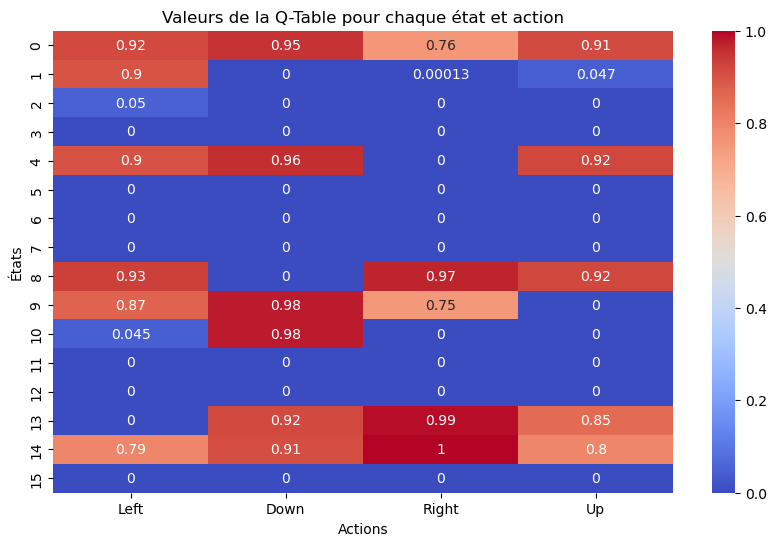

In [10]:
import seaborn as sns  
# Créer une carte thermique (heatmap) de la Q-Table
plt.figure(figsize=(10, 6))
sns.heatmap(q_table, annot=True, cmap="coolwarm", cbar=True, xticklabels=['Left', 'Down', 'Right', 'Up'], yticklabels=np.arange(n_states))
plt.title("Valeurs de la Q-Table pour chaque état et action")
plt.xlabel("Actions")
plt.ylabel("États")
plt.show()